<a href="https://colab.research.google.com/github/sumitsingh34/research-paper-g-mixup-enhancement/blob/master/Augumented_with_new_techique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install PyTorch Geometric

In [ ]:
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done



# Dataset Selection


In [ ]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='.', name='IMDB-BINARY')


#Graph Show


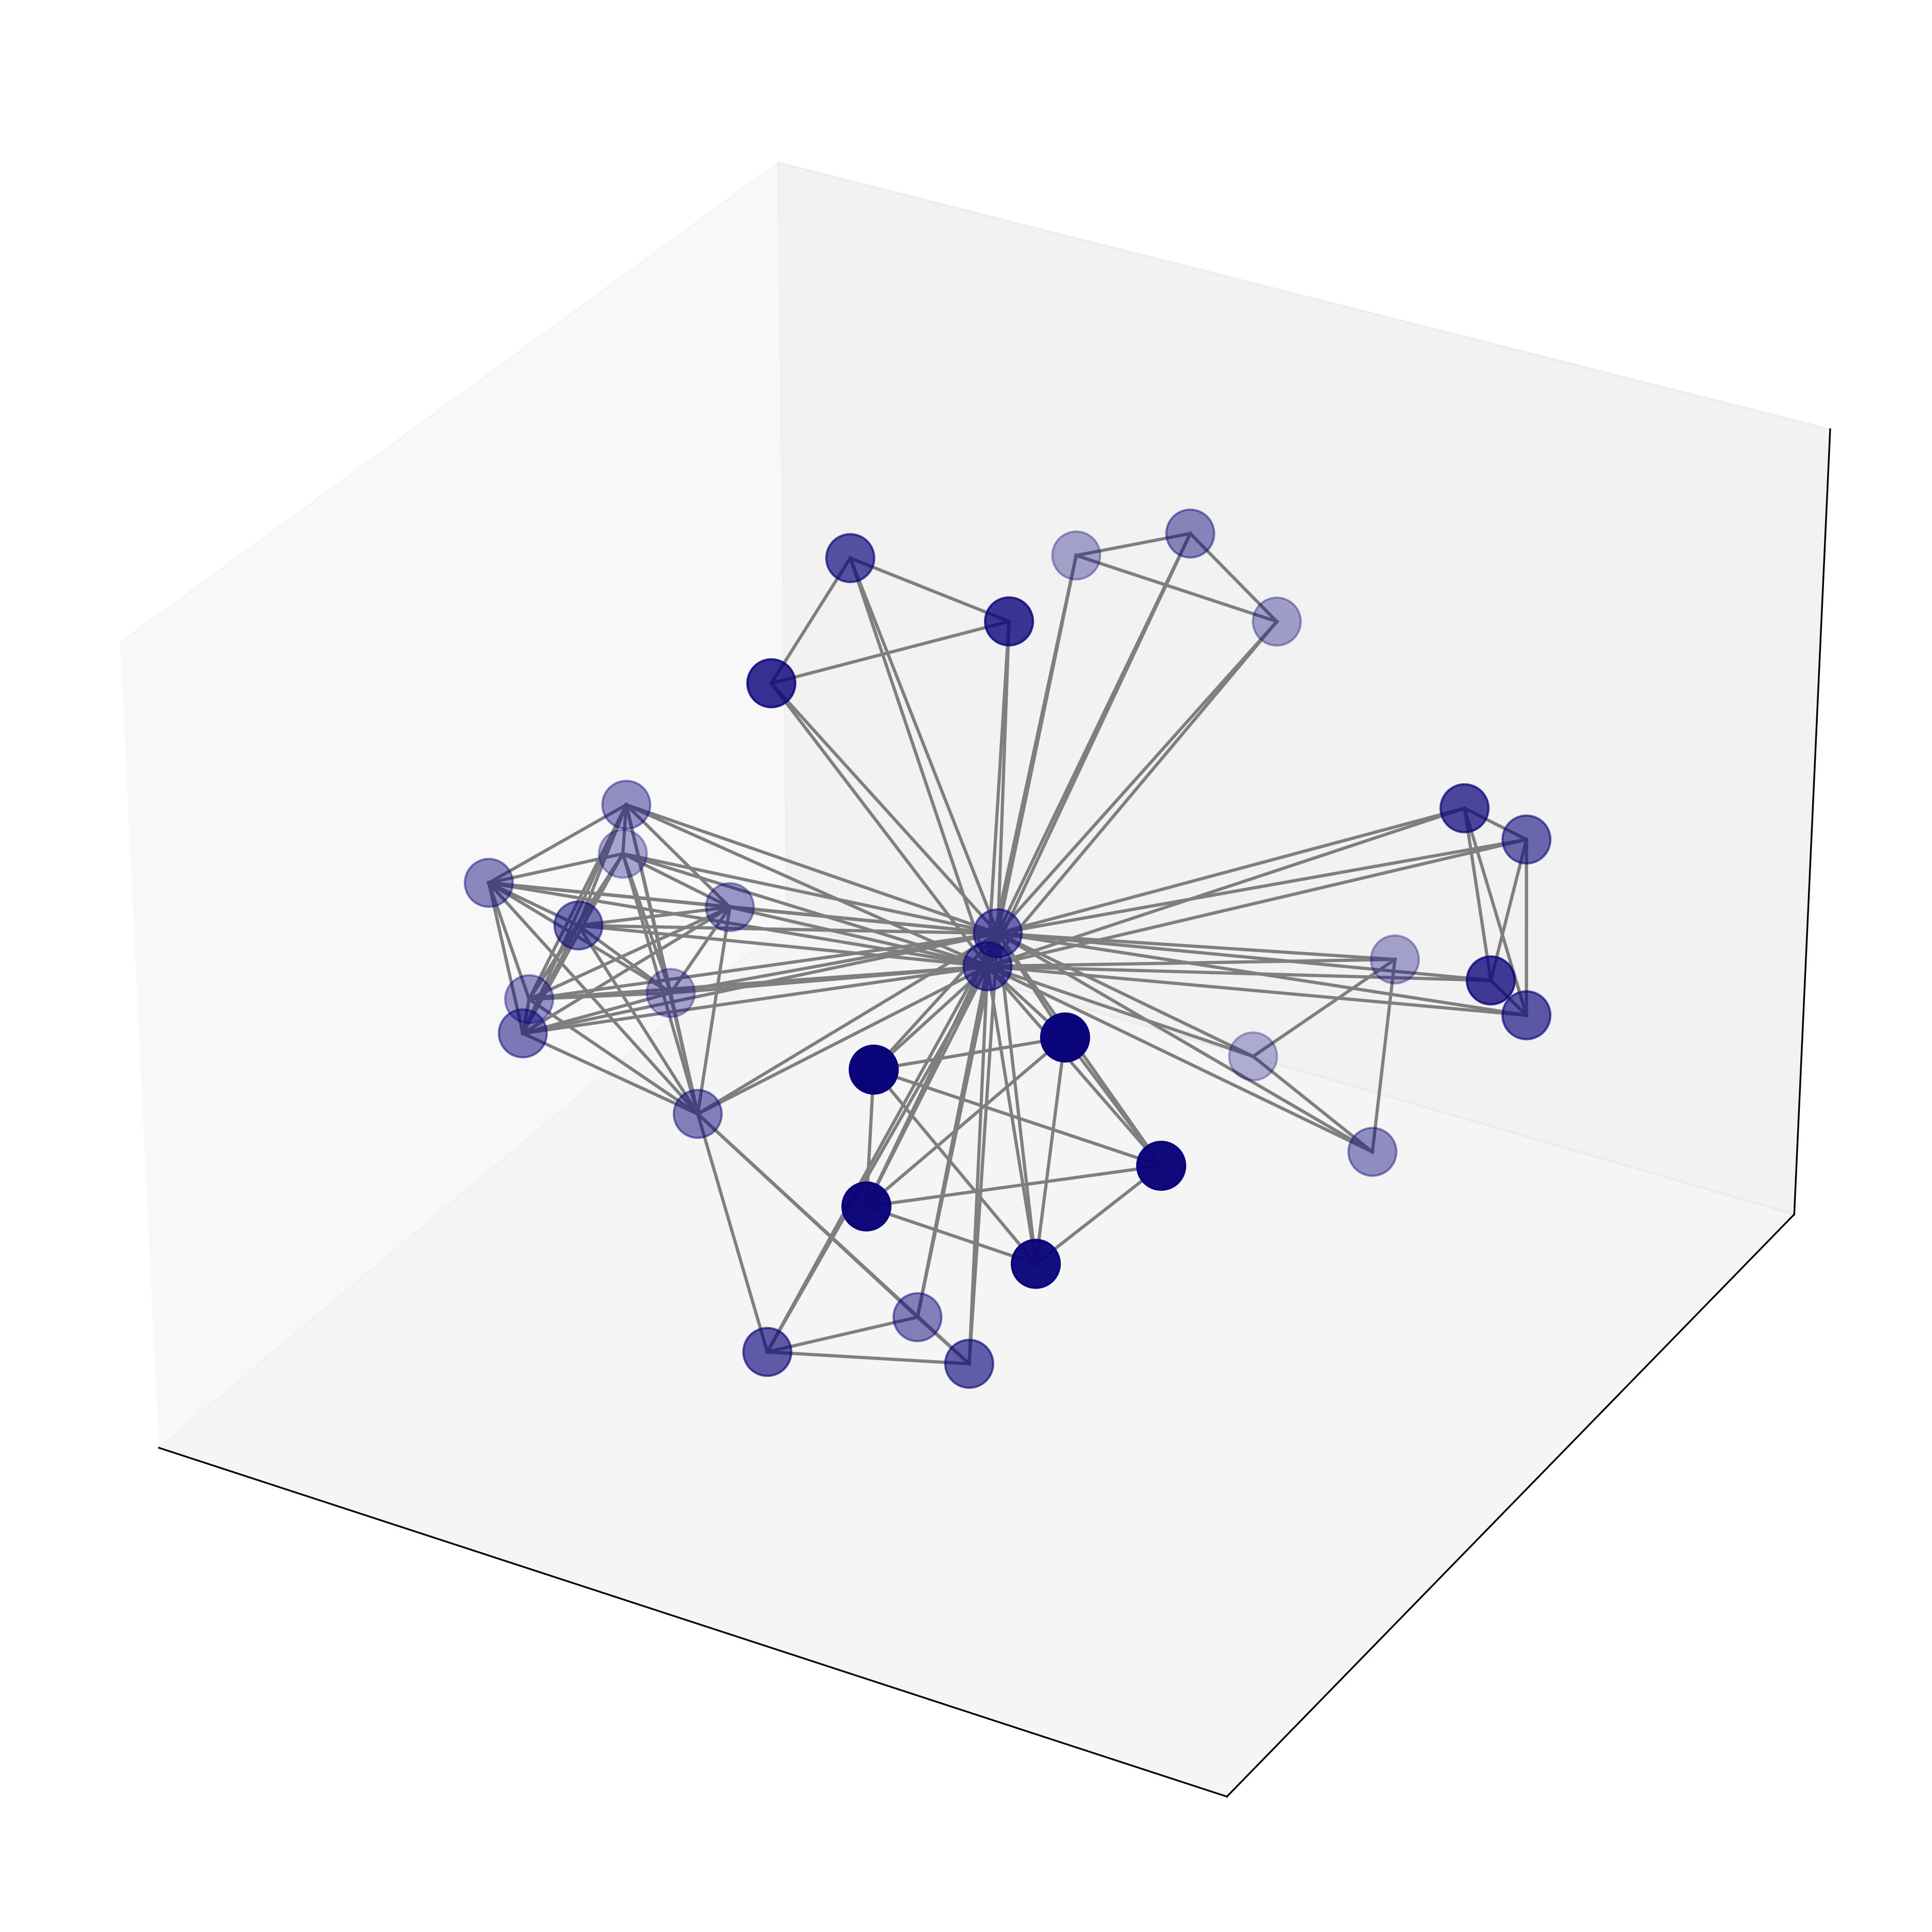

In [ ]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[1], to_undirected=True)
pos = nx.spring_layout(G, dim=3, seed=0)

node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

ax.scatter(*node_xyz.T, s=500, c="#0A047A")

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

plt.show()

In [ ]:
import random
import networkx as nx
def add_edges_to_biconnected(graph, cut_vertex):
  print('biconnected')
  G = nx.Graph(graph)
  biconnected_components = list(nx.biconnected_components(graph))
  #print(biconnected_components)
  for i in biconnected_components:
    i.remove(cut_vertex) #random.choice(my_list)
  graph.add_edge(random.choice(list(biconnected_components[0])), random.choice(list(biconnected_components[1])))

#Util.py

In [ ]:
from typing import List, Tuple
from skimage.restoration import denoise_tv_chambolle
import numpy as np
import copy
import torch_geometric.transforms as T
from torch_geometric.utils import degree, to_dense_adj
import torch.nn.functional as F
import torch
import random

from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data


class NormalizedDegree(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        deg = degree(data.edge_index[0], dtype=torch.float)
        deg = (deg - self.mean) / self.std
        data.x = deg.view(-1, 1)
        # print( data.x.shape )
        return data


def prepare_synthetic_dataset(dataset):
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max(max_degree, degs[-1].max().item())

        for data in dataset:
            degs = degree(data.edge_index[0], dtype=torch.long)

            data.x = F.one_hot(degs.to(torch.int64), num_classes=max_degree+1).to(torch.float)
            print(data.x.shape)


        return dataset


def prepare_dataset(dataset):
    if dataset.data.x is None:
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max(max_degree, degs[-1].max().item())

        if max_degree < 1000:
            dataset.transform = T.OneHotDegree(max_degree)
        else:
            deg = torch.cat(degs, dim=0).to(torch.float)
            mean, std = deg.mean().item(), deg.std().item()
            dataset.transform = NormalizedDegree(mean, std)

    return dataset




def graph_numpy2tensor(graphs: List[np.ndarray]) -> torch.Tensor:
    """
    Convert a list of np arrays to a pytorch tensor
    :param graphs: [K (N, N) adjacency matrices]
    :return:
        graph_tensor: [K, N, N] tensor
    """
    graph_tensor = np.array(graphs)
    return torch.from_numpy(graph_tensor).float()



def align_graphs_modified(graphs: List[np.ndarray],
                 padding: bool = False, N: int = None) -> Tuple[List[np.ndarray], List[np.ndarray], int, int]:
    """
    Align multiple graphs by sorting their nodes by descending node degrees

    :param graphs: a list of binary adjacency matrices
    :param padding: whether padding graphs to the same size or not
    :return:
        aligned_graphs: a list of aligned adjacency matrices
        normalized_node_degrees: a list of sorted normalized node degrees (as node distributions)
    """
    num_nodes = [graphs[i].shape[0] for i in range(len(graphs))]
    max_num = max(num_nodes)
    min_num = min(num_nodes)

    aligned_graphs = []
    normalized_node_degrees = []
    for i in range(len(graphs)):
        num_i = graphs[i].shape[0]

        node_degree = 0.5 * np.sum(graphs[i], axis=0) + 0.5 * np.sum(graphs[i], axis=1)
        node_degree /= np.sum(node_degree)
        idx = np.argsort(node_degree)  # ascending
        idx = idx[::-1]  # descending

        sorted_node_degree = node_degree[idx]
        sorted_node_degree = sorted_node_degree.reshape(-1, 1)

        sorted_graph = copy.deepcopy(graphs[i])
        sorted_graph = sorted_graph[idx, :]
        sorted_graph = sorted_graph[:, idx]

        max_num = max(max_num, N)

        if padding:
            # normalized_node_degree = np.ones((max_num, 1)) / max_num
            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:num_i, :] = sorted_node_degree

            aligned_graph = np.zeros((max_num, max_num))
            aligned_graph[:num_i, :num_i] = sorted_graph

            normalized_node_degrees.append(normalized_node_degree)
            aligned_graphs.append(aligned_graph)
        else:
            normalized_node_degrees.append(sorted_node_degree)
            aligned_graphs.append(sorted_graph)

        if N:
            aligned_graphs = [aligned_graph[:N, :N] for aligned_graph in aligned_graphs]
            normalized_node_degrees = normalized_node_degrees[:N]

    return aligned_graphs, normalized_node_degrees, max_num, min_num



def align_x_graphs(graphs: List[np.ndarray], node_x: List[np.ndarray], padding: bool = False, N: int = None) -> Tuple[List[np.ndarray], List[np.ndarray], int, int]:
    """
    Align multiple graphs by sorting their nodes by descending node degrees

    :param graphs: a list of binary adjacency matrices
    :param padding: whether padding graphs to the same size or not
    :return:
        aligned_graphs: a list of aligned adjacency matrices
        normalized_node_degrees: a list of sorted normalized node degrees (as node distributions)
    """
    num_nodes = [graphs[i].shape[0] for i in range(len(graphs))]
    max_num = max(num_nodes)
    min_num = min(num_nodes)

    aligned_graphs = []
    normalized_node_degrees = []
    for i in range(len(graphs)):
        num_i = graphs[i].shape[0]

        node_degree = 0.5 * np.sum(graphs[i], axis=0) + 0.5 * np.sum(graphs[i], axis=1)
        node_degree /= np.sum(node_degree)
        idx = np.argsort(node_degree)  # ascending
        idx = idx[::-1]  # descending

        sorted_node_degree = node_degree[idx]
        sorted_node_degree = sorted_node_degree.reshape(-1, 1)

        sorted_graph = copy.deepcopy(graphs[i])
        sorted_graph = sorted_graph[idx, :]
        sorted_graph = sorted_graph[:, idx]

        node_x = copy.deepcopy( node_x )
        sorted_node_x = node_x[ idx, :]

        max_num = max(max_num, N)
        # if max_num < N:
        #     max_num = max(max_num, N)
        if padding:
            # normalized_node_degree = np.ones((max_num, 1)) / max_num
            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:num_i, :] = sorted_node_degree

            aligned_graph = np.zeros((max_num, max_num))
            aligned_graph[:num_i, :num_i] = sorted_graph

            normalized_node_degrees.append(normalized_node_degree)
            aligned_graphs.append(aligned_graph)

            # added
            aligned_node_x = np.zeros((max_num, 1))
            aligned_node_x[:num_i, :] = sorted_node_x


        else:
            normalized_node_degrees.append(sorted_node_degree)
            aligned_graphs.append(sorted_graph)

        if N:
            aligned_graphs = [aligned_graph[:N, :N] for aligned_graph in aligned_graphs]
            normalized_node_degrees = normalized_node_degrees[:N]

            #added
            aligned_node_x = aligned_node_x[:N]

    return aligned_graphs, aligned_node_x, normalized_node_degrees, max_num, min_num




def two_graphons_mixup(two_graphons, la=0.5, num_sample=20):
  print('two graphons mix up')

  label = two_graphons[0][0]
  new_graphon = 0

  sample_graph_label = torch.from_numpy(label).type(torch.float32)
  print('sample_graph_label',sample_graph_label)

  sample_graphs = []
  for i in range(num_sample):
    print('i',i)
    #print('two_graphons',two_graphons)
    #G=nx.Graph(two_graphons)
    #print('G',G)
    biconnected_components = list(nx.biconnected_component(two_graphons))
    cut_vertex_list = list(nx.articulation_points(two_graphons))
    for cut_vertex in cut_vertex_list:
      add_edges_to_biconnected(two_graphons, cut_vertex)



      A = torch.from_numpy(G)
      print('A',A)
      edge_index, _ = dense_to_sparse(A)

      num_nodes = int(torch.max(edge_index)) + 1

      pyg_graph = Data()
      pyg_graph.y = sample_graph_label
      pyg_graph.edge_index = edge_index
      pyg_graph.num_nodes = num_nodes
      sample_graphs.append(pyg_graph)

      # print(edge_index)
  return sample_graphs

def split_class_graphs(dataset):

  y_list = []
  for data in dataset:
      y_list.append(tuple(data.y.tolist()))
      # print(y_list)
  num_classes = len(set(y_list))

  all_graphs_list = []
  for graph in dataset:
      adj = to_dense_adj(graph.edge_index)[0].numpy()
      all_graphs_list.append(adj)

  class_graphs = []
  for class_label in set(y_list):
      c_graph_list = [all_graphs_list[i] for i in range(len(y_list)) if y_list[i] == class_label]
      class_graphs.append( ( np.array(class_label), c_graph_list ) )

  return class_graphs




def universal_svd(aligned_graphs: List[np.ndarray], threshold: float = 2.02) -> np.ndarray:
  """
  Estimate a graphon by universal singular value thresholding.

  Reference:
  Chatterjee, Sourav.
  "Matrix estimation by universal singular value thresholding."
  The Annals of Statistics 43.1 (2015): 177-214.

  :param aligned_graphs: a list of (N, N) adjacency matrices
  :param threshold: the threshold for singular values
  :return: graphon: the estimated (r, r) graphon model
  """
  aligned_graphs = graph_numpy2tensor(aligned_graphs).to( "cuda" )
  num_graphs = aligned_graphs.size(0)

  if num_graphs > 1:
      sum_graph = torch.mean(aligned_graphs, dim=0)
  else:
      sum_graph = aligned_graphs[0, :, :]  # (N, N)

  num_nodes = sum_graph.size(0)

  u, s, v = torch.svd(sum_graph)
  singular_threshold = threshold * (num_nodes ** 0.5)
  binary_s = torch.lt(s, singular_threshold)
  s[binary_s] = 0
  graphon = u @ torch.diag(s) @ torch.t(v)
  graphon[graphon > 1] = 1
  graphon[graphon < 0] = 0
  graphon = graphon.cpu().numpy()
  torch.cuda.empty_cache()
  return graphon

def stat_graph(graphs_list: List[Data]):
    num_total_nodes = []
    num_total_edges = []
    for graph in graphs_list:
        num_total_nodes.append(graph.num_nodes)
        num_total_edges.append(  graph.edge_index.shape[1] )
    avg_num_nodes = sum( num_total_nodes ) / len(graphs_list)
    avg_num_edges = sum( num_total_edges ) / len(graphs_list) / 2.0
    avg_density = avg_num_edges / (avg_num_nodes * avg_num_nodes)

    median_num_nodes = np.median( num_total_nodes )
    median_num_edges = np.median(num_total_edges)
    median_density = median_num_edges / (median_num_nodes * median_num_nodes)

    return avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density

#Graphon_estimator.py

#Model.py

In [ ]:
from torch_geometric.nn import GINConv, global_mean_pool, JumpingKnowledge
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN
from math import ceil
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool, JumpingKnowledge
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.nn import GraphConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv, DenseGraphConv, dense_mincut_pool, dense_diff_pool
from torch_geometric.utils import to_dense_batch, to_dense_adj


class GIN(torch.nn.Module):
    def __init__(self, num_features=1, num_classes=1, num_hidden=32):
        super(GIN, self).__init__()

        dim = num_hidden

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        # x = global_add_pool(x, batch)
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

#Gmixup.py

In [ ]:
import time

from torch_geometric.utils import degree
from torch.autograd import Variable

import random
from torch.optim.lr_scheduler import StepLR
import argparse


def prepare_dataset_x(dataset):
    if dataset[0].x is None:
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max( max_degree, degs[-1].max().item() )
            data.num_nodes = int( torch.max(data.edge_index) ) + 1

        if max_degree < 2000:
            # dataset.transform = T.OneHotDegree(max_degree)

            for data in dataset:
                degs = degree(data.edge_index[0], dtype=torch.long)
                data.x = F.one_hot(degs, num_classes=max_degree+1).to(torch.float)
        else:
            deg = torch.cat(degs, dim=0).to(torch.float)
            mean, std = deg.mean().item(), deg.std().item()
            for data in dataset:
                degs = degree(data.edge_index[0], dtype=torch.long)
                data.x = ( (degs - mean) / std ).view( -1, 1 )
    return dataset


def prepare_dataset_onehot_y(dataset):

    y_set = set()
    for data in dataset:
        y_set.add(int(data.y))
    num_classes = len(y_set)

    for data in dataset:
        data.y = F.one_hot(data.y, num_classes=num_classes).to(torch.float)[0]
    return dataset


def mixup_cross_entropy_loss(input, target, size_average=True):
    """Origin: https://github.com/moskomule/mixup.pytorch
    in PyTorch's cross entropy, targets are expected to be labels
    so to predict probabilities this loss is needed
    suppose q is the target and p is the input
    loss(p, q) = -\sum_i q_i \log p_i
    """
    assert input.size() == target.size()
    assert isinstance(input, Variable) and isinstance(target, Variable)
    loss = - torch.sum(input * target)
    return loss / input.size()[0] if size_average else loss




def train(model, train_loader):
    model.train()
    loss_all = 0
    graph_all = 0
    for data in train_loader:
        # print( "data.y", data.y )
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        y = data.y.view(-1, num_classes)
        loss = mixup_cross_entropy_loss(output, y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        graph_all += data.num_graphs
        optimizer.step()
    loss = loss_all / graph_all
    return model, loss


def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        y = data.y.view(-1, num_classes)
        loss += mixup_cross_entropy_loss(output, y).item() * data.num_graphs
        y = y.max(dim=1)[1]
        correct += pred.eq(y).sum().item()
        total += data.num_graphs
    acc = correct / total
    loss = loss / total
    return acc, loss

#Finding Biconnected Component and its Count

---



#Finding no.of elements in biconnected components of G

#Calling Gmixup.py

In [ ]:
lam_range = [0.005, 0.01]
gmixup = True
num_epochs = 100

num_hidden = 64
batch_size = 32
learning_rate = 0.01
ge = "MC"
aug_ratio = 0.15
aug_num = 10
model = "GIN"
device = "cpu"

dataset = list(dataset)

for graph in dataset:
    graph.y = graph.y.view(-1)

dataset = prepare_dataset_onehot_y(dataset)

random.shuffle( dataset )

train_nums = int(len(dataset) * 0.7)
train_val_nums = int(len(dataset) * 0.8)

avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density = stat_graph(dataset[: train_nums])
print(f"avg num nodes of training graphs: { avg_num_nodes }")
print(f"avg num edges of training graphs: { avg_num_edges }")
print(f"avg density of training graphs: { avg_density }")
print(f"median num nodes of training graphs: { median_num_nodes }")
print(f"median num edges of training graphs: { median_num_edges }")
print(f"median density of training graphs: { median_density }")

resolution = int(median_num_nodes)
for i in dataset:
  print('data',i)
  break
graphons=[]
if gmixup == True:
    num_sample = int(train_nums * aug_ratio / aug_num)
    class_graphs= split_class_graphs(dataset[:train_nums])
    for label, graphs in class_graphs:
      print(f"label: {label}, num_graphs:{len(graphs)}" )
      align_graphs_list, normalized_node_degrees, max_num, min_num = align_graphs_modified(
          graphs, padding=True, N=resolution)
      print(f"aligned graph {align_graphs_list[0].shape}" )

      print(f"ge: {ge}")
      graphon = universal_svd(align_graphs_list, threshold=0.2)
      graphons.append((label, graphon))
    for label, graphon in graphons:
        print(f"graphon info: label:{label}; mean: {graphon.mean()}, shape, {graphon.shape}")
    new_graph = []
    num_sample = int( train_nums * aug_ratio / aug_num )
    lam_list = np.random.uniform(low=lam_range[0], high=lam_range[1], size=(aug_num,))
    for lam in lam_list:
        print( f"lam: {lam}" )
        print(f"num_sample: {num_sample}")
        two_graphons = random.sample(graphons, 1)
        new_graph += two_graphons_mixup(two_graphons, la=lam, num_sample=num_sample)
        print(f"label: {new_graph[-1].y}")


    print('original dataset',len(dataset))
    # new_graph = []
    # networkx_graphs = [to_networkx(data, to_undirected=True) for data in dataset]
    # for graph in networkx_graphs:
    #   biconnected_components = list(nx.biconnected_components(graph))
    #   cut_vertex_list = list(nx.articulation_points(graph))
    #   for cut_vertex in cut_vertex_list:
    #     add_edges_to_biconnected(graph, cut_vertex)
    #   new_graph.append(graph)
    # print('new graph length',len(new_graph))



    # Calculate statistics of the new graphs
    avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density = stat_graph(new_graph)

    # Append the augmented graphs to the dataset obtained from gmixup
    dataset = new_graph + dataset
    print(len(dataset))
    train_nums = train_nums + len(new_graph)
    train_val_nums = train_val_nums + len(new_graph)


dataset = prepare_dataset_x( dataset )

print(f"num_features: {dataset[0].x.shape}" )
print(f"num_classes: {dataset[0].y.shape}"  )

num_features = dataset[0].x.shape[1]
num_classes = dataset[0].y.shape[0]

train_dataset = dataset[:train_nums]
random.shuffle(train_dataset)
val_dataset = dataset[train_nums:train_val_nums]
test_dataset = dataset[train_val_nums:]

print(f"train_dataset size: {len(train_dataset)}")
print(f"val_dataset size: {len(val_dataset)}")
print(f"test_dataset size: {len(test_dataset)}" )


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


if model == "GIN":
    model = GIN(num_features=num_features, num_classes=num_classes, num_hidden=num_hidden).to(device)
else:
    print(f"No model."  )


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

total_acc = 0

# Create empty numpy arrays to accumulate metrics
val_acc_array = np.zeros(num_epochs - 1)
val_loss_array = np.zeros(num_epochs - 1)
test_acc_array = np.zeros(num_epochs - 1)
test_loss_array = np.zeros(num_epochs - 1)
train_loss_array = np.zeros(num_epochs - 1)


for epoch in range(1, num_epochs):
    model, train_loss = train(model, train_loader)
    train_acc = 0
    val_acc, val_loss = test(model, val_loader)
    test_acc, test_loss = test(model, test_loader)
    total_acc += test_acc
    scheduler.step()

     # Assign metrics for the current epoch to the corresponding array indices
    val_acc_array[epoch - 1] = val_acc
    val_loss_array[epoch - 1] = val_loss
    test_acc_array[epoch - 1] = test_acc
    test_loss_array[epoch - 1] = test_loss
    train_loss_array[epoch -1] = train_loss

    print('Epoch: {:03d}, Train Loss: {:.6f}, Val Loss: {:.6f}, Test Loss: {:.6f},  Val Acc: {: .6f}, Test Acc: {: .6f}'.format(
      epoch, train_loss, val_loss, test_loss, val_acc, test_acc))

print(f'\n Avg Accuracy:     {(total_acc / num_epochs)*100:.2f}%')

avg num nodes of training graphs: 19.695714285714285
avg num edges of training graphs: 97.08
avg density of training graphs: 0.2502570359749461
median num nodes of training graphs: 17.0
median num edges of training graphs: 132.0
median density of training graphs: 0.45674740484429066
data Data(edge_index=[2, 118], y=[2], num_nodes=18)
label: [0. 1.], num_graphs:352
aligned graph (17, 17)
ge: MC
label: [1. 0.], num_graphs:348
aligned graph (17, 17)
ge: MC
graphon info: label:[0. 1.]; mean: 0.40757185220718384, shape, (17, 17)
graphon info: label:[1. 0.]; mean: 0.483394593000412, shape, (17, 17)
lam: 0.005625182555784659
num_sample: 10
two graphons mix up
sample_graph_label tensor([0., 1.])
i 0
G Graph with 32 nodes and 128 edges


AttributeError: ignored

#Graphs for Test and Validation Loss & Accurecy

In [ ]:
import matplotlib.pyplot as plt2
epochs = np.arange(1, num_epochs)
plt2.figure(figsize=(15, 10))

# Plotting Test Accuracy and Loss
plt2.subplot(2, 3, 1)
plt2.plot(epochs, test_acc_array, marker='o')
plt2.title('Test Acc over Epochs')
plt2.xlabel('Epochs')
plt2.ylabel('Accuracy')
plt2.legend()

plt2.subplot(2, 3, 2)
plt2.plot(epochs, test_loss_array, marker='o', color='orange')
plt2.title('Test Loss over Epochs')
plt2.xlabel('Epochs')
plt2.ylabel('Loss')
plt2.legend()

#plotting training loss
plt2.subplot(2, 3, 3)
plt2.plot(epochs, train_loss_array, marker='o', color='green')
plt2.title('Training Loss over Epochs')
plt2.xlabel('Epochs')
plt2.ylabel('Loss')
plt2.legend()

# Plotting Validation Accuracy and Loss
plt2.subplot(2, 3, 4)
plt2.plot(epochs, val_acc_array, marker='o')
plt2.title('Validation Acc over Epochs', fontsize=20)
plt2.xlabel('Epochs')
plt2.ylabel('Accuracy')
plt2.legend()

plt2.subplot(2, 3, 5)
plt2.plot(epochs, val_loss_array, marker='o', color='orange')
plt2.title('Validation Loss over Epochs', fontsize=20)
plt2.xlabel('Epochs')
plt2.ylabel('Loss')
plt2.legend()

plt2.tight_layout(rect=[0, 0, 1, 0.96])  # Increase the value in the last parameter if needed

plt2.suptitle('Metrics over Epochs (Total Epochs: {})'.format(num_epochs), y=1.02, fontsize=24)

plt2.tight_layout()
plt2.show()

# Rolling Mean Graphs

In [ ]:
import matplotlib.pyplot as plt3
import pandas as pd

epochs = np.arange(1, num_epochs)
# Creating rolling means for each array
val_loss_rolling_mean = pd.Series(val_loss_array, index=epochs).rolling(5).mean()
val_acc_rolling_mean = pd.Series(val_acc_array, index=epochs).rolling(5).mean()
test_loss_rolling_mean = pd.Series(test_loss_array, index=epochs).rolling(5).mean()
test_acc_rolling_mean = pd.Series(test_acc_array, index=epochs).rolling(5).mean()
train_loss_rolling_mean = pd.Series(train_loss_array, index=epochs).rolling(5).mean()

# Creating subplots for each metric and its rolling mean
plt3.figure(figsize=(18, 15))



# Subplot 1 - Test Loss and its Rolling Mean
plt3.subplot(3, 2, 1)
plt3.plot(epochs, test_loss_rolling_mean, marker='', linestyle='-', color='orange')
plt3.title('Test Loss & Mean')
plt3.xlabel('Epochs')
plt3.ylabel('Loss')

# Subplot 2 - Test Accuracy and its Rolling Mean
plt3.subplot(3, 2, 2)
plt3.plot(epochs, test_acc_rolling_mean, marker='', linestyle='-', color='red')
plt3.title('Test Acc & Mean')
plt3.xlabel('Epochs')
plt3.ylabel('Accuracy')


# Subplot 3 - Training Loss and its Rolling Mean
plt3.subplot(3, 2, 3)
plt3.plot(epochs, train_loss_rolling_mean, marker='', linestyle='-', color='green')
plt3.title('Training Loss & Mean')
plt3.xlabel('Epochs')
plt3.ylabel('Loss')


# Subplot 2 - Validation Accuracy and its Rolling Mean
plt3.subplot(3, 2, 4)
plt3.plot(epochs, val_acc_rolling_mean, marker='', linestyle='-', color='black')
plt3.title('Val Acc &  Mean')
plt3.xlabel('Epochs')
plt3.ylabel('Accuracy')


# Subplot 5 - Validation Loss and its Rolling Mean
plt3.subplot(3, 2, 5)
plt3.plot(epochs, val_loss_rolling_mean, marker='', linestyle='-', color='blue')
plt3.title('Val Loss & Mean')
plt3.xlabel('Epochs')
plt3.ylabel('Loss')


# Adjust layout to prevent overlap
plt3.tight_layout()

# Adding a single title at the top
plt3.suptitle('Metrics and Rolling Means over Epochs: {}'.format(num_epochs), y=1.02, fontsize=24)

plt3.show()


In [ ]:
import torch

# Create a dense tensor
dense_tensor = torch.tensor([[1, 0, 0], [0, 0, 2], [0, 3, 0]])

# Convert dense tensor to sparse tensor
sparse_tensor = torch.sparse_coo_tensor(dense_tensor.nonzero().t(), dense_tensor[dense_tensor.nonzero().t()[0], dense_tensor.nonzero().t()[1]], dense_tensor.size())

# Print the dense and sparse tensors
print("Dense Tensor:")
print(dense_tensor)

print("\nSparse Tensor:")
print(sparse_tensor)


In [ ]:
import networkx as nx

# Create a sample graph
G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 0), (1, 3), (3, 4)])

# Find biconnected components
biconnected_components = list(nx.biconnected_components(G))

# Print the biconnected components
print("Biconnected components:")
for component in biconnected_components:
    print(component)
